
<img src="logos/Picture1.png" alt="sd" style="width: 50%; height: auto;">

# Supplementary 2
**Variable Selection and Multicollinearity Control**

Articule title

This supplementary section details the variable selection process used to reduce multicollinearity and identify the environmental predictors that best explain the spatial distribution of _Acer saccharum_ (Sugar Maple) and _Acer rubrum_ (Red Maple) across Quebec. Following the analytical framework presented in the main article (to appear in [Journal Name]), we combined principal component analysis (PCA), correlations, and LightGBM-based feature importance to remove highly correlated variables (|r| > 0.9) and retain those contributing most to species differentiation. The resulting set of variables provides a parsimonious representation of the climatic and edaphic gradients influencing maple occurrence, serving as the foundation for subsequent clustering and niche separation analyses between both species.



## Data import and preparation

The script loads the CSV dataset (resultados_bioclimaticos_2.csv) containing climatic (cite), edaphic, and occurrence data for both species. Columns are read with explicit data types to ensure numeric consistency. Records corresponding to _Acer saccharinum_ (“EA”) are excluded, and duplicates based on geographic coordinates and species identity are removed to avoid spatial redundancy.

In [65]:
#testing



dtype_spec = {
    'latitude': 'float64',
    'longitude': 'float64',
    'geocode': 'object',
    'essence': 'object',
    'RES_CO_REG': 'object'
}

csv_file_path = 'data/resultados_bioclimaticos_2.csv'

In [66]:
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import pandas as pd

In [68]:
dfff = pd.read_csv(csv_file_path, dtype=dtype_spec)

In [69]:

#os.environ['OPENBLAS_NUM_THREADS'] = '1'
#os.environ['MKL_NUM_THREADS'] = '1'
#os.environ['NUMEXPR_NUM_THREADS'] = '1'
#os.environ['OMP_NUM_THREADS'] = '1'

In [70]:
#import os
#import requests
#import geopandas as gpd
#import zipfile
#import xarray as xr
#from shapely.geometry import mapping
#import glob


In [71]:
dfff = dfff.drop(['geocode'], axis=1) #
dfff = dfff[dfff['essence'] != 'EA']

In [72]:
dfff.head(3)

,latitude,longitude,densite,essence,RES_CO_REG,bio10,bio11,bio12,bio13,bio14,...,bio5,bio6,bio7,bio8,bio9,clay,elev,forest,ph,sand
0,48.396359,-68.500026,85.0,EO,01,15.244105,-12.083439,1037.675,143.95,36.850,...,23.157057,-18.553493,41.710550,3.165525,-0.290782,26.0,200,90,4.55,37.0
1,47.996187,-68.500146,95.0,ES,01,15.910181,-12.535620,1024.825,147.40,33.825,...,24.034576,-19.773650,43.808228,6.911122,-3.073537,11.0,364,94,4.20,56.0
2,47.849696,-68.513409,75.0,ES,01,15.910181,-12.535620,1024.825,147.40,33.825,...,24.034576,-19.773650,43.808228,6.911122,-3.073537,11.0,392,100,4.20,56.0


In [73]:
catego = dfff['essence'].unique()
print(catego)

['EO' 'ES']


In [74]:
print(dfff.shape)       # tamaño original

(1719639, 45)


In [75]:
dfff = dfff.drop_duplicates(subset=['latitude', 'longitude', 'essence'])

print(dfff.shape) # tamaño después de eliminar duplicados

(1658314, 45)


In [76]:
color_mapping = {
    'ES':1, 'EO':2
    #'EI':3,
   # 'EA':3
}
colors = ['#bc5090', '#ff6361'
          #'#58508d',
         # '#888f7d'
         ]  # Rojo, Verde, Azul, etc.


In [77]:
# Mapeo de nombres completos
full_names = {
    #'EA': 'Acer saccharinum (Érable argenté o Arce plateado)',
    'EO': 'Acer rubrum (Érable rouge o Arce rojo)',
    'ES': 'Acer saccharum (Érable à sucre o Arce de azúcar)'
}

In [78]:
num_nan = dfff.isna().sum()
num_nan

latitude      0
longitude     0
densite       0
essence       0
RES_CO_REG    0
bio10         0
bio11         0
bio12         0
bio13         0
bio14         0
bio15         0
bio16         0
bio17         0
bio18         0
bio19         0
bio1          0
bio20         0
bio21         0
bio22         0
bio23         0
bio24         0
bio25         0
bio26         0
bio27         0
bio28         0
bio29         0
bio2          0
bio30         0
bio31         0
bio32         0
bio33         0
bio34         0
bio35         0
bio3          0
bio4          0
bio5          0
bio6          0
bio7          0
bio8          0
bio9          0
clay          0
elev          0
forest        0
ph            0
sand          0
dtype: int64

In [79]:
num_neg_999 = (dfff == -999).sum()
num_neg_999

latitude      0
longitude     0
densite       0
essence       0
RES_CO_REG    0
bio10         0
bio11         0
bio12         0
bio13         0
bio14         0
bio15         0
bio16         0
bio17         0
bio18         0
bio19         0
bio1          0
bio20         0
bio21         0
bio22         0
bio23         0
bio24         0
bio25         0
bio26         0
bio27         0
bio28         0
bio29         0
bio2          0
bio30         0
bio31         0
bio32         0
bio33         0
bio34         0
bio35         0
bio3          0
bio4          0
bio5          0
bio6          0
bio7          0
bio8          0
bio9          0
clay          0
elev          0
forest        0
ph            0
sand          0
dtype: int64

Missing values and invalid placeholders (e.g. –999) are detected. A brief summary of the dataset dimensions and categories of the variable essence is printed to confirm data integrity before analysis.

In [80]:
numeric_cols = dfff.select_dtypes(include=[np.number])


is_neg_999 = numeric_cols == -999
columns_with_neg_999 = is_neg_999.any()
print("Columnas con valores igual a -999:")
print(columns_with_neg_999[columns_with_neg_999].index.tolist())

Columnas con valores igual a -999:
[]


In [81]:
#dfff = dfff.drop('unified', axis=1)

In [82]:

print(dfff.columns)

Index(['latitude', 'longitude', 'densite', 'essence', 'RES_CO_REG', 'bio10',
       'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18',
       'bio19', 'bio1', 'bio20', 'bio21', 'bio22', 'bio23', 'bio24', 'bio25',
       'bio26', 'bio27', 'bio28', 'bio29', 'bio2', 'bio30', 'bio31', 'bio32',
       'bio33', 'bio34', 'bio35', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7',
       'bio8', 'bio9', 'clay', 'elev', 'forest', 'ph', 'sand'],
      dtype='object')


In [83]:
import seaborn as sns



In [84]:
#pip install PCA StandardScaler

## Exploratory Principal Component Analysis (PCA)

All numeric predictors are standardized and submitted to PCA to visualise major environmental gradients and potential collinearity among variables.
The script plots the explained variance of each component and produces biplots (PCA0–PCA1–PCA2) where arrows represent the loadings of original variables, showing how climatic and edaphic factors structure the data space for both maple species.

In [85]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [86]:
numeric_columns = dfff.select_dtypes(include='number').columns.tolist()
dfff_numeric = dfff[numeric_columns]

In [87]:
dfff_numeric = dfff.drop(columns=['densite']).select_dtypes(include='number')

In [88]:
scaler = StandardScaler()
dfff_scaled = scaler.fit_transform(dfff_numeric)

In [89]:
import numpy as np

In [90]:
pca = PCA()
pca_components = pca.fit_transform(dfff_scaled)

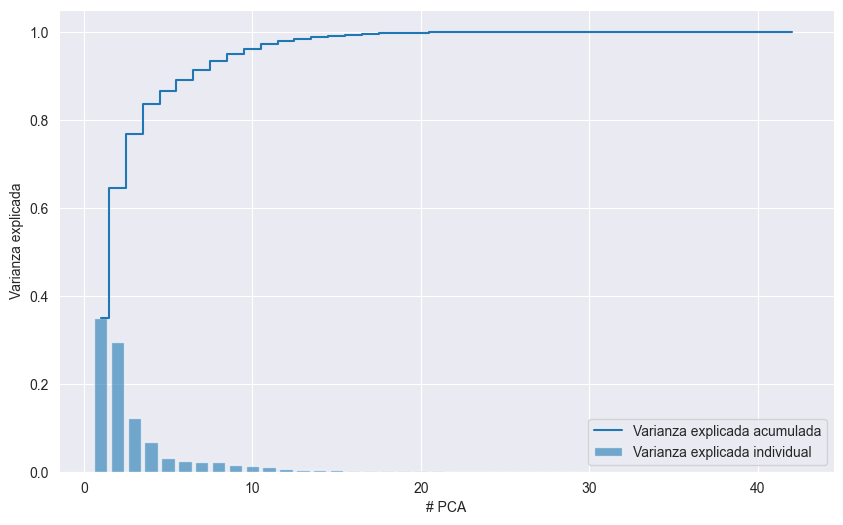

In [91]:
explained_variance = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza explicada individual')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Varianza explicada acumulada')
plt.xlabel('# PCA')
plt.ylabel('Varianza explicada')
plt.title('')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Three principal components explain 77% aprox...

In [92]:
np.sum(pca.explained_variance_ratio_[0:3])

np.float64(0.7665317824606489)

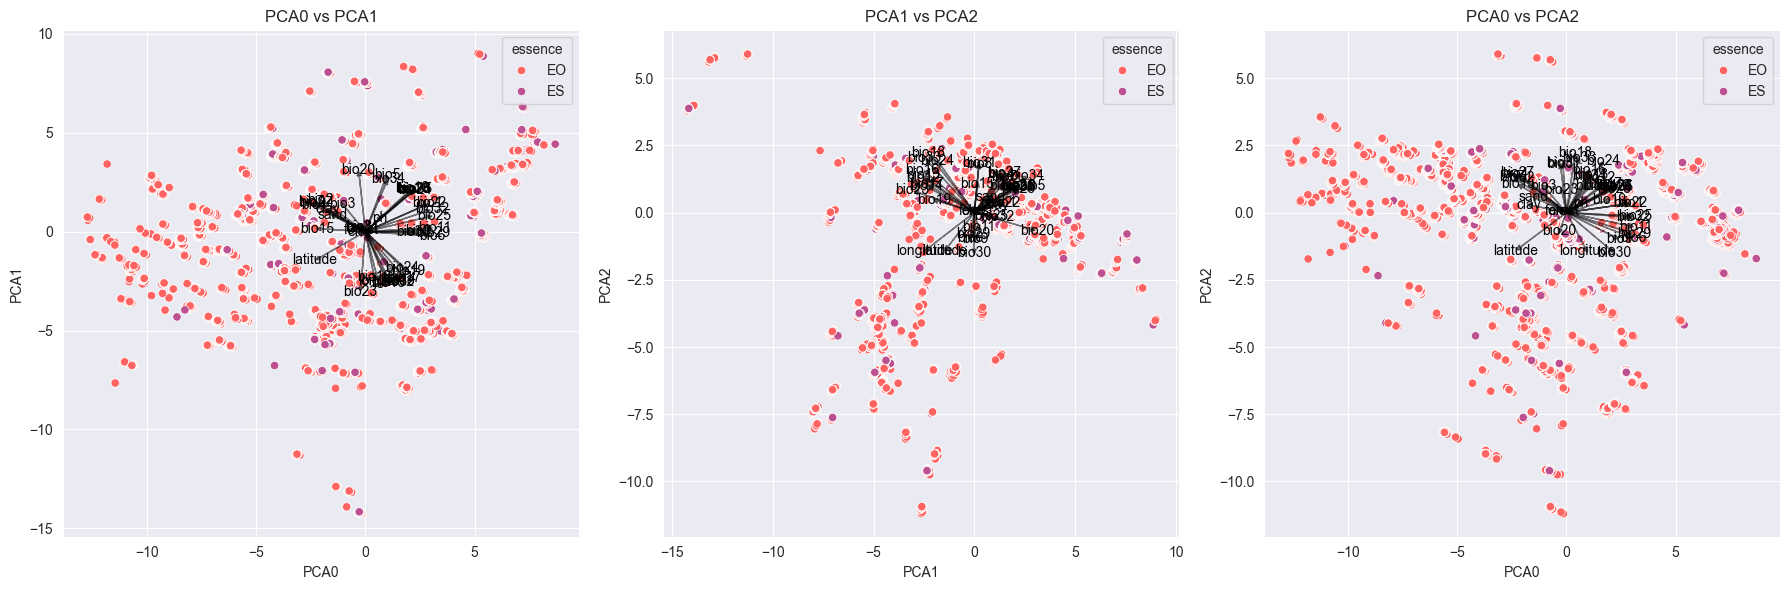

In [93]:
# Crear un DataFrame para los tres primeros componentes principales
pca_df = pd.DataFrame(data=pca_components[:, 0:3], columns=['PCA0', 'PCA1', 'PCA2'])

# Añadir la columna 'essence' para la visualización
pca_df['essence'] = dfff['essence'].values

# Obtener los loadings (coeficientes) de las variables originales en los componentes principales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Escalar los loadings para mejorar la visualización
scaling_factor = 3
loadings_scaled = loadings * scaling_factor

# Definir los gráficos biplot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# PCA0 vs PCA1
sns.scatterplot(x='PCA0', y='PCA1', hue='essence', palette={key: colors[color_mapping[key] - 1] for key in color_mapping}, data=pca_df, ax=axes[0])
axes[0].set_title('PCA0 vs PCA1')
axes[0].set_xlabel('PCA0')
axes[0].set_ylabel('PCA1')

# Añadir flechas de loadings
for i in range(loadings.shape[0]):
    axes[0].arrow(0, 0, loadings_scaled[i, 0], loadings_scaled[i, 1], color='black', alpha=0.5, head_width=0.2, head_length=0.2)
    axes[0].text(loadings_scaled[i, 0]*1.1, loadings_scaled[i, 1]*1.1, dfff_numeric.columns[i], color='black', ha='center', va='center')

# PCA1 vs PCA2
sns.scatterplot(x='PCA1', y='PCA2', hue='essence', palette={key: colors[color_mapping[key] - 1] for key in color_mapping}, data=pca_df, ax=axes[1])
axes[1].set_title('PCA1 vs PCA2')
axes[1].set_xlabel('PCA1')
axes[1].set_ylabel('PCA2')

# Añadir flechas de loadings
for i in range(loadings.shape[0]):
    axes[1].arrow(0, 0, loadings_scaled[i, 1], loadings_scaled[i, 2], color='black', alpha=0.5, head_width=0.2, head_length=0.2)
    axes[1].text(loadings_scaled[i, 1]*1.1, loadings_scaled[i, 2]*1.1, dfff_numeric.columns[i], color='black', ha='center', va='center')

# PCA0 vs PCA2
sns.scatterplot(x='PCA0', y='PCA2', hue='essence', palette={key: colors[color_mapping[key] - 1] for key in color_mapping}, data=pca_df, ax=axes[2])
axes[2].set_title('PCA0 vs PCA2')
axes[2].set_xlabel('PCA0')
axes[2].set_ylabel('PCA2')

# Añadir flechas de loadings
for i in range(loadings.shape[0]):
    axes[2].arrow(0, 0, loadings_scaled[i, 0], loadings_scaled[i, 2], color='black', alpha=0.5, head_width=0.2, head_length=0.2)
    axes[2].text(loadings_scaled[i, 0]*1.1, loadings_scaled[i, 2]*1.1, dfff_numeric.columns[i], color='black', ha='center', va='center')

# Ajustar el espacio entre los subgráficos
plt.tight_layout()
plt.show()

### Variable contribution ranking

Loadings are extracted and summed to quantify the total contribution of each variable to the first three principal components. This step highlights which predictors drive the greatest multivariate differentiation.

In [94]:
# Obtenemos las cargas (loadings) de las variables en los primeros tres componentes principales
loadings = pca.components_[:3]
loadings_df = pd.DataFrame(loadings.T, index=dfff_numeric.columns, columns=[f'PC{i+1}' for i in range(3)])
loadings_df['Total_Contribution'] = loadings_df.abs().sum(axis=1)
sorted_loadings = loadings_df.sort_values(by='Total_Contribution', ascending=False)
print(sorted_loadings.head(40))

                PC1       PC2       PC3  Total_Contribution
bio24      0.134718 -0.156684  0.255583            0.546984
bio33      0.046070 -0.213295  0.272249            0.531615
bio18      0.032359 -0.199006  0.296840            0.528205
bio16      0.082823 -0.221356  0.211942            0.516121
bio12      0.114573 -0.218018  0.171544            0.504136
bio27     -0.178266  0.125740  0.198180            0.502186
bio7      -0.195564  0.127571  0.177718            0.500853
latitude  -0.183393 -0.125276 -0.188865            0.497533
bio21      0.181240  0.182711  0.132468            0.496419
bio26      0.177322  0.185401  0.133207            0.495930
bio13      0.090477 -0.219810  0.183981            0.494268
bio4      -0.185951  0.114118  0.192052            0.492121
bio34      0.081052  0.227257  0.183765            0.492074
bio10      0.169275  0.189897  0.132574            0.491746
bio35      0.179620  0.185011  0.125118            0.489749
longitude  0.075167 -0.214888 -0.192585 

In [95]:
#selected_variables = sorted_loadings[sorted_loadings['Total_Contribution'] > 0.45].index.tolist()
#!pip install lightgbm
# Crear un nuevo DataFrame con las variables seleccionadas
#dfff_selected = dfff_numeric[selected_variables]

## Feature importance using LightGBM

A Light Gradient Boosting Machine (LightGBM) classifier is trained to predict species identity (essence) from environmental variables. The resulting feature‐importance scores quantify the relative predictive power of each variable.

In [96]:
#from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [97]:
X = dfff.drop(columns=[ 'essence', 'densite', 'RES_CO_REG', 'longitude',
                        'latitude', 'elev', 'forest'])  # Excluyendo 'geocode', 'essence' y 'densite'
Y = dfff['essence']

The resulting feature‐importance scores quantify the relative predictive power of each variable and reveal which climatic and edaphic gradients best discriminate between _Acer saccharum_ and _A. rubrum_. This step is crucial for assessing whether the two species occupy distinct environmental niches—thus supporting the use of separate clustering analyses—or whether their occurrences can be treated as a continuum within shared ecological gradients.
In other words, LightGBM provides an empirical basis to decide whether niche differentiation or niche overlap predominates across Quebec’s maple populations.

In [98]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Crear y entrenar el modelo LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, Y_train)

# Importancia de las características
importances = lgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

[LightGBM] [Info] Number of positive: 396055, number of negative: 764764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6543
[LightGBM] [Info] Number of data points in the train set: 1160819, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341186 -> initscore=-0.658014
[LightGBM] [Info] Start training from score -0.658014
   Feature  Importance
36      ph         367
35    clay         324
37    sand         269
0    bio10         173
2    bio12         132
28    bio3         130
1    bio11         128
5    bio15         107
34    bio9          91
23   bio31          78
4    bio14          76
3    bio13          75
7    bio17          75
18   bio27          72
21    bio2          70
26   bio34          69
10    bio1          66
22   bio30          60
33    bio8          60
32    bio7          56
15   bio24         

In [99]:
from sklearn.preprocessing import LabelEncoder

In [100]:
# Convertir Y a valores numéricos si es necesario
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.3, random_state=42)

# Crear y entrenar el modelo LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, Y_train)

# Importancia de las características
importances = lgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)


[LightGBM] [Info] Number of positive: 396055, number of negative: 764764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6543
[LightGBM] [Info] Number of data points in the train set: 1160819, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341186 -> initscore=-0.658014
[LightGBM] [Info] Start training from score -0.658014
   Feature  Importance
36      ph         367
35    clay         324
37    sand         269
0    bio10         173
2    bio12         132
28    bio3         130
1    bio11         128
5    bio15         107
34    bio9          91
23   bio31          78
4    bio14          76
3    bio13          75
7    bio17          75
18   bio27          72
21    bio2          70
26   bio34          69
10    bio1          66
22   bio30          60
33    bio8          60
32    bio7          56
15   bio24         

In [101]:
imp_df = feature_importance_df.copy()

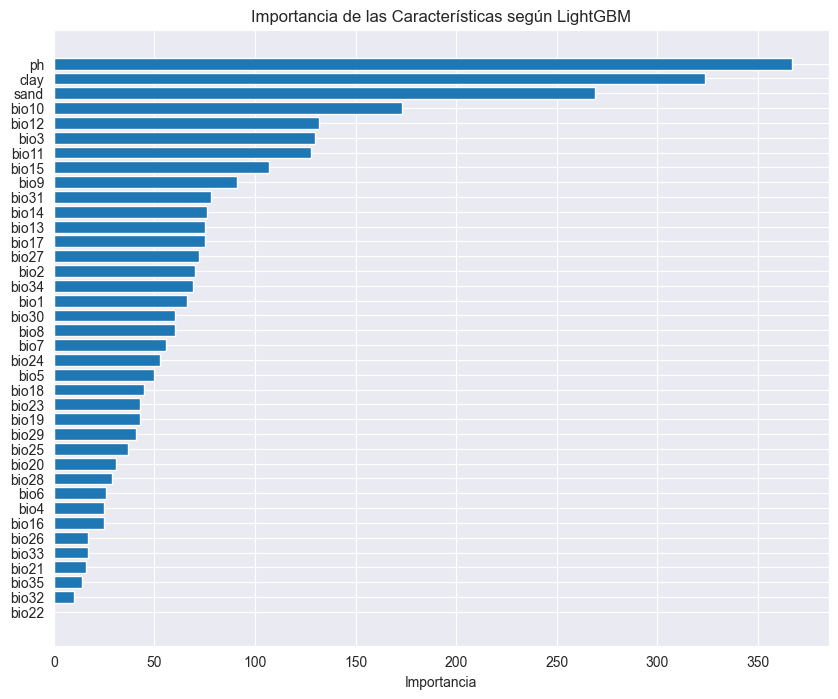

In [102]:
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de las Características según LightGBM')
plt.show()

## Multicollinearity filtering

Pairwise Pearson correlations are computed, and a custom function (select_features_lgbm) iteratively retains high‐importance variables while discarding those correlated above |r| > 0.9 with previously selected predictors. This produces a parsimonious set of independent predictors for subsequent niche‐modelling and clustering analyses.

In [103]:
corr_matrix = X.corr(method='pearson')

In [104]:
def select_features_lgbm(importance_df, corr_matrix, corr_threshold=0.9):
    """
    importance_df: DataFrame con columnas ['Feature','Importance'] ordenado desc.
    corr_matrix: matriz de correlación (DataFrame cuadrado)
    corr_threshold: umbral de colinealidad, por defecto 0.9
    """
    selected = []
    for f in importance_df['Feature']:
        if all(abs(corr_matrix.loc[f, sel]) < corr_threshold for sel in selected):
            selected.append(f)
    return selected



In [105]:
# Aplicamos la función
selected_features = select_features_lgbm(feature_importance_df, corr_matrix, corr_threshold=0.9)


In [106]:
print("Variables seleccionadas evitando multicolinealidad:")
print(selected_features)
print("Total:", len(selected_features))

Variables seleccionadas evitando multicolinealidad:
['ph', 'clay', 'sand', 'bio10', 'bio12', 'bio3', 'bio11', 'bio15', 'bio9', 'bio31', 'bio14', 'bio27', 'bio2', 'bio34', 'bio1', 'bio30', 'bio8', 'bio24', 'bio18', 'bio23', 'bio20']
Total: 21


In [107]:
X_selected = X[selected_features]

X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y_encoded, test_size=0.3, random_state=42)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, Y_train)

print("Score con variables seleccionadas:", lgb_model.score(X_test, Y_test))

[LightGBM] [Info] Number of positive: 396055, number of negative: 764764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3477
[LightGBM] [Info] Number of data points in the train set: 1160819, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.341186 -> initscore=-0.658014
[LightGBM] [Info] Start training from score -0.658014
Score con variables seleccionadas: 0.6791565744379341


## Exporting of the final variable set

The filtered dataset containing the selected variables, species identity, and geographic coordinates is saved as df_important.csv, which serves as the input for later modelling steps described in the main manuscript. Variables were selected through an integrated approach that combined three complementary criteria: (i) their contribution to total variance in the principal component analysis (PCA), (ii) their predictive importance in differentiating _Acer saccharum_ and _A. rubrum_ according to LightGBM, and (iii) the absence of multicollinearity among retained predictors. This ensures that the final set of variables captures the most informative and independent environmental gradients relevant to maple distribution across Quebec.

In [108]:
#dft = dfff[[ 'essence', 'densite', 'RES_CO_REG','latitude', 'forest', 'longitude', 'elev',
#            'ph', 'clay', 'sand', 'bio1', 'bio10', 'bio12', 'bio3', 'bio11', 'bio15', 'bio9',
#           'bio31', 'bio14', 'bio27', 'bio2', 'bio34', 'bio30', 'bio8', 'bio24',
#           'bio18', 'bio23', 'bio20' ]]

In [109]:
dft = dfff[[ 'essence', 'densite', 'RES_CO_REG','latitude', 'forest', 'longitude', 'elev',
            'ph', 'clay', 'sand', 'bio1', 'bio2','bio3', 'bio8', 'bio9','bio10', 'bio11', 'bio12',
             'bio14', 'bio15', 'bio18', 'bio20', 'bio23', 'bio24', 'bio27', 'bio30', 'bio31', 'bio34']]

In [110]:
dft.to_csv('data/df_important.csv', index=False) #dff